# Segmentation and classification of lymphoblastic leukaemia using quantum neural network

In [1]:
import os
from PIL import Image
from torchvision import transforms

# Define paths
input_dir = '/kaggle/input/all-idb1-dataset/All-IDB dataset/'  # Replace with your dataset folder name
output_dir = '/kaggle/working/'  # Working directory where output will be saved

# Define the transformations
flip_horizontal = transforms.RandomHorizontalFlip(p=1)  # Always apply horizontal flip
flip_vertical = transforms.RandomVerticalFlip(p=1)      # Always apply vertical flip
rotate_90 = transforms.RandomRotation(degrees=(90, 90))  # Rotate 90 degrees
rotate_180 = transforms.RandomRotation(degrees=(180, 180))  # Rotate 180 degrees

# Function to apply flips multiple times and save images
def process_images(input_folder, output_folder, num_flips):
    total_images_saved = 0

    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for root, dirs, files in os.walk(input_folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, file)

                # Open the image
                img = Image.open(img_path)

                # Save original image
                relative_path = os.path.relpath(root, input_folder)
                output_subfolder = os.path.join(output_folder, relative_path)
                if not os.path.exists(output_subfolder):
                    os.makedirs(output_subfolder)
                img.save(os.path.join(output_subfolder, file))
                total_images_saved += 1  # Count original image

                # Apply transformations and save multiple versions
                for i in range(1, num_flips + 1):
                    # Apply a sequence of transformations to create new variations
                    if i % 4 == 1:
                        transformed_img = flip_horizontal(img)
                    elif i % 4 == 2:
                        transformed_img = flip_vertical(img)
                    elif i % 4 == 3:
                        transformed_img = rotate_90(img)
                    else:
                        transformed_img = rotate_180(img)

                    # Save the transformed image
                    transformed_img.save(os.path.join(output_subfolder, f'transformed_{i}_{file}'))
                    total_images_saved += 1

    return total_images_saved

# Process the folders
train_folder = os.path.join(input_dir, 'train')
val_folder = os.path.join(input_dir, 'val')

# Assuming train has two subfolders
train_subfolders = [os.path.join(train_folder, subfolder) for subfolder in os.listdir(train_folder)]
val_subfolders = [os.path.join(val_folder, subfolder) for subfolder in os.listdir(val_folder)]

# Flip first train subfolder 5 times
train_first_saved = process_images(train_subfolders[0], os.path.join(output_dir, 'train', os.path.basename(train_subfolders[0])), num_flips=5)

# Flip second train subfolder 2 times
train_second_saved = process_images(train_subfolders[1], os.path.join(output_dir, 'train', os.path.basename(train_subfolders[1])), num_flips=15)

# Flip both val subfolders 30 times
val_first_saved = process_images(val_subfolders[0], os.path.join(output_dir, 'val', os.path.basename(val_subfolders[0])), num_flips=30)
val_second_saved = process_images(val_subfolders[1], os.path.join(output_dir, 'val', os.path.basename(val_subfolders[1])), num_flips=30)

# Print the total images saved
print(f"Total number of images saved in 'train/{os.path.basename(train_subfolders[0])}' (including flips): {train_first_saved}")
print(f"Total number of images saved in 'train/{os.path.basename(train_subfolders[1])}' (including flips): {train_second_saved}")
print(f"Total number of images saved in 'val/{os.path.basename(val_subfolders[0])}' (including flips): {val_first_saved}")
print(f"Total number of images saved in 'val/{os.path.basename(val_subfolders[1])}' (including flips): {val_second_saved}")


Total number of images saved in 'train/Blast' (including flips): 600
Total number of images saved in 'train/nonblast' (including flips): 1600
Total number of images saved in 'val/Blast' (including flips): 930
Total number of images saved in 'val/nonblast' (including flips): 930


In [ ]:
import shutil

# Specify the folder you want to zip
folder_to_zip = 'train'  # Change this to your folder name
zip_filename = 'train.zip'

# Create a zip file
shutil.make_archive(zip_filename[:-4], 'zip', folder_to_zip)

# Move the zip file to the output directory for downloading
shutil.move(zip_filename, '/kaggle/working/' + zip_filename)


# Import Libraries

In [4]:
import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

torch.manual_seed(42)
np.random.seed(42)

# Plotting
import matplotlib.pyplot as plt

# OpenMP: number of parallel threads.
os.environ["OMP_NUM_THREADS"] = "1"

# Install Library

In [3]:
! pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 31.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 83.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.7 MB/s eta 0:00:00


# Hyperparameters

In [5]:
n_qubits = 4                # Number of qubits
step = 0.0008               # Learning rate
batch_size = 16            # Number of samples for each training step
num_epochs = 100              # Number of training epochs
q_depth = 8                # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.2    # Learning rate reduction applied every 10 epochs.
q_delta = 0.002              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

In [6]:
dev = qml.device("default.qubit", wires=n_qubits)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# IMPORT Lymphoblastic Leukaemia DATASET

In [9]:
data_transforms = {
    "train": transforms.Compose(
        [
            # transforms.RandomResizedCrop(224),     # uncomment for data augmentation
            # transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # Normalize input channels using mean values and standard deviations of ImageNet.
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "/kaggle/working/"
image_datasets = {
    x if x == "train" else "validation": datasets.ImageFolder(
        os.path.join(data_dir, x), data_transforms[x]
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes

# Initialize dataloader
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

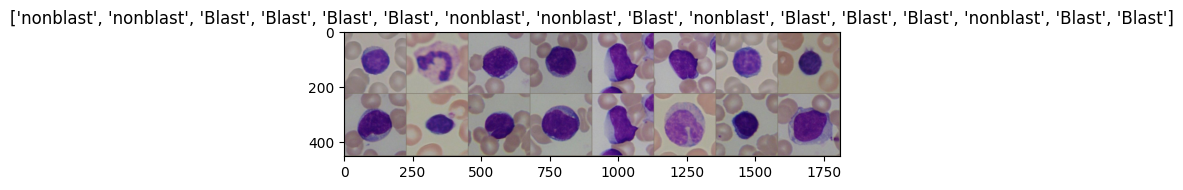

In [10]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["validation"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

# Hadamard gates

In [11]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

# Variational Quantum Circuit

In [12]:
@qml.qnode(dev)
def quantum_net(q_input_features, q_weights_flat):
    """
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

# DressedQuantumNet

In [13]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

# ResNet18

In [14]:
weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
model_hybrid = torchvision.models.resnet18(weights=weights)

for param in model_hybrid.parameters():
    param.requires_grad = False


# Notice that model_hybrid.fc is the last layer of ResNet18
model_hybrid.fc = DressedQuantumNet()

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 199MB/s]


# CrossEntropyLoss

In [15]:
criterion = nn.CrossEntropyLoss()


# Adam

In [16]:
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)


In [17]:
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
)


# Model Training

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0  # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    print("Training started:")

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ["train", "validation"]:
            if phase == "train":
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, labels in dataloaders[phase]:
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # Track/compute gradient and make an optimization step only when training
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Print iteration results
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                print(
                    "Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(
                        phase,
                        epoch + 1,
                        num_epochs,
                        it + 1,
                        n_batches + 1,
                        time.time() - since_batch,
                    ),
                    end="\r",
                    flush=True,
                )
                it += 1

            # Print epoch results
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print(
                "Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        ".format(
                    "train" if phase == "train" else "validation  ",
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                    epoch_acc,
                )
            )

            # Check if this is the best model wrt previous epochs
            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "validation" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

            # Update learning rate
            if phase == "train":
                scheduler.step()

    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print(
        "Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60)
    )
    print("Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc))
    return model


In [19]:
model_hybrid = train_model(
    model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs
)

Training started:
Phase: train Epoch: 1/100 Loss: 0.6013 Acc: 0.7214        
Phase: validation   Epoch: 1/100 Loss: 0.7808 Acc: 0.5000        
Phase: train Epoch: 2/100 Loss: 0.5101 Acc: 0.7432        
Phase: validation   Epoch: 2/100 Loss: 0.5012 Acc: 0.9263        
Phase: train Epoch: 3/100 Loss: 0.3048 Acc: 0.9368        
Phase: validation   Epoch: 3/100 Loss: 0.3132 Acc: 0.9000        
Phase: train Epoch: 4/100 Loss: 0.1832 Acc: 0.9614        
Phase: validation   Epoch: 4/100 Loss: 0.4408 Acc: 0.7887        
Phase: train Epoch: 5/100 Loss: 0.1371 Acc: 0.9659        
Phase: validation   Epoch: 5/100 Loss: 0.3994 Acc: 0.8183        
Phase: train Epoch: 6/100 Loss: 0.1291 Acc: 0.9605        
Phase: validation   Epoch: 6/100 Loss: 0.3368 Acc: 0.8715        
Phase: train Epoch: 7/100 Loss: 0.0938 Acc: 0.9759        
Phase: validation   Epoch: 7/100 Loss: 0.2037 Acc: 0.9108        
Phase: train Epoch: 8/100 Loss: 0.0985 Acc: 0.9695        
Phase: validation   Epoch: 8/100 Loss: 0.2184 Ac

In [20]:
# Save the trained model
model_path = 'model_hybrid.pth'  # Specify the path where you want to save the model
torch.save(model_hybrid.state_dict(), model_path)
print(f'Model saved to {model_path}')

Model saved to model_hybrid.pth


# Trained Model

In [21]:
# Example input tensor (make sure to match the input size expected by the model)
# Replace `example_input` with actual input data
example_input = torch.randn(1, 3, 224, 224).to(device)  # Dummy input for demonstration
with torch.no_grad():
    predictions = model_hybrid(example_input)

print(predictions)


tensor([[0.0306, 0.8933]], device='cuda:0')


# Prediction Results

In [22]:
def visualize_model(model, num_images=6, fig_name="Predictions"):
    images_so_far = 0
    _fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for _i, (inputs, labels) in enumerate(dataloaders["validation"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("[{}]".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return

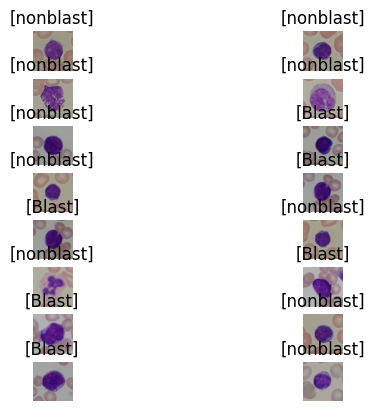

In [23]:
visualize_model(model_hybrid, num_images=batch_size)
plt.show()

# PREDICTION RESULTS WITH ACTUAL AND PREDICTED LABELS

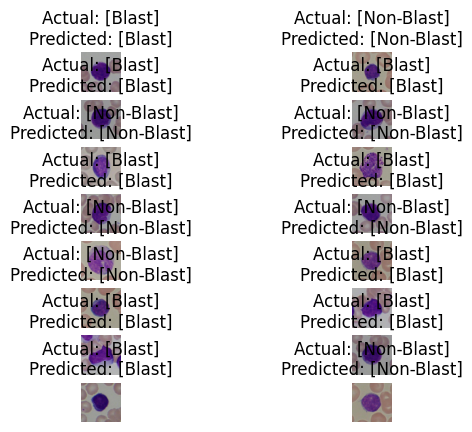

In [28]:
import matplotlib.pyplot as plt
import torch

def visualize_model(model, num_images=6, fig_name="Predictions"):
    images_so_far = 0
    _fig = plt.figure(fig_name)
    model.eval()  # Set model to evaluation mode
    
    with torch.no_grad():
        for _i, (inputs, labels) in enumerate(dataloaders["validation"]):
            inputs = inputs.to(device)  # Move inputs to device
            labels = labels.to(device)  # Move labels to device
            outputs = model(inputs)  # Get model predictions
            _, preds = torch.max(outputs, 1)  # Get predicted labels

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)  # Create subplot
                ax.axis("off")  # Hide axes

                # Set the title to show both actual and predicted labels
                ax.set_title(f'Actual: [{class_names[labels[j].item()]}]\nPredicted: [{class_names[preds[j].item()]}]')

                imshow(inputs.cpu().data[j])  # Display the image

                if images_so_far == num_images:  # Stop if we've displayed enough images
                    return

    plt.show()  # Show the plot

# Example call to the function
visualize_model(model_hybrid, num_images=batch_size)


# 100# Predictionn of the Normal Slices

Accuracy: 100.00%


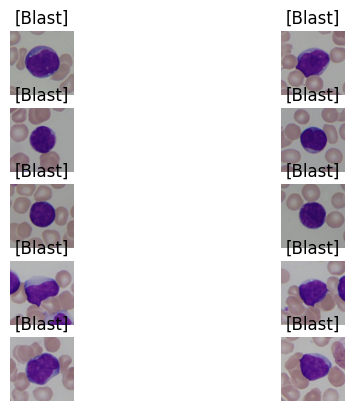

In [26]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Assuming you already have your model and DataLoader defined
# Define your class names (adjust as needed)
class_names = ['Blast', 'Non-Blast']  # Example class names

# Define the transformations for the validation set
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Assuming you have a validation dataset path
val_dir = '/kaggle/input/all-idb1-dataset/All-IDB dataset/val'
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Function to visualize model predictions
def visualize_model(model, dataloader, class_names, num_images=6, fig_name="Predictions"):
    images_so_far = 0
    correct_predictions = 0
    total_predictions = 0

    _fig = plt.figure(fig_name)
    model.eval()
    
    with torch.no_grad():
        for _i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("[{}]".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                # Update correct predictions and total predictions
                total_predictions += 1
                if preds[j] == labels[j]:
                    correct_predictions += 1
                
                if images_so_far == num_images:
                    break
            
            if images_so_far == num_images:
                break

    # Calculate accuracy
    accuracy = (correct_predictions / total_predictions) * 100
    print(f'Accuracy: {accuracy:.2f}%')

# Call the visualize_model function with the model and validation DataLoader
visualize_model(model_hybrid, val_loader, class_names, num_images=10)  # Set num_images as desired
plt.show()


# 100% PREDICTION of the Pneumonia Slices 

Accuracy: 100.00%


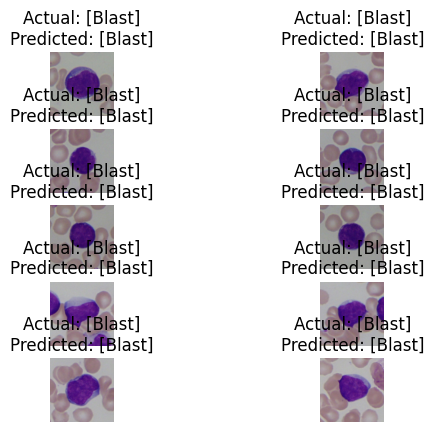

In [27]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Assuming you already have your model and DataLoader defined
# Define your class names (adjust as needed)
class_names = ['Blast', 'Non-Blast']  # Example class names

# Define the transformations for the validation set
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Assuming you have a validation dataset path
val_dir = '/kaggle/input/all-idb1-dataset/All-IDB dataset/val'
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Function to visualize model predictions
def visualize_model(model, dataloader, class_names, num_images=6, fig_name="Predictions"):
    images_so_far = 0
    correct_predictions = 0
    total_predictions = 0

    _fig = plt.figure(fig_name)
    model.eval()
    
    with torch.no_grad():
        for _i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                # Display actual class and predicted class
                ax.set_title(f"Actual: [{class_names[labels[j]]}]\nPredicted: [{class_names[preds[j]]}]")
                imshow(inputs.cpu().data[j])
                
                # Update correct predictions and total predictions
                total_predictions += 1
                if preds[j] == labels[j]:
                    correct_predictions += 1
                
                if images_so_far == num_images:
                    break
            
            if images_so_far == num_images:
                break

    # Calculate accuracy
    accuracy = (correct_predictions / total_predictions) * 100
    print(f'Accuracy: {accuracy:.2f}%')

# Call the visualize_model function with the model and validation DataLoader
visualize_model(model_hybrid, val_loader, class_names, num_images=10)  # Set num_images as desired
plt.show()
